In [ ]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from toraniko import factor_math, model, styles

In [ ]:
# ── Universe selection ──────────────────────────────────────────
# Change this to "sp500" to switch back to the S&P 500 dataset.
UNIVERSE = "russell3000"    # "sp500" | "russell3000"
data_dir = f"../data/{UNIVERSE}"

returns_df = pl.read_parquet(f"{data_dir}/returns_df.parquet")
mkt_cap_df = pl.read_parquet(f"{data_dir}/mkt_cap_df.parquet")
sector_df = pl.read_parquet(f"{data_dir}/sector_df.parquet")
value_df = pl.read_parquet(f"{data_dir}/value_df.parquet")

def to_us(df: pl.LazyFrame) -> pl.LazyFrame:
    return df.with_columns(
        pl.col("date").dt.cast_time_unit("us")
    )

returns_df = to_us(returns_df)
mkt_cap_df = to_us(mkt_cap_df)
sector_df = to_us(sector_df)
value_df = to_us(value_df)

print(f"Universe: {UNIVERSE}")
print(f"Data dir: {data_dir}")
print(f"Returns: {returns_df.shape}, Mkt cap: {mkt_cap_df.shape}")
print(f"Sectors: {sector_df.shape}, Value: {value_df.shape}")

In [ ]:
mom_df = styles.factor_mom(
    returns_df=returns_df,
    trailing_days=252,  # ~1 year of trading days
    half_life=126,     # ~6 months decay
    lag=20,            # 1 month lag
    winsor_factor=0.01
).collect()

# Construct size factor
sze_df = styles.factor_sze(
    mkt_cap_df=mkt_cap_df,
    lower_decile=0.2,  # Exclude smallest 20%
    upper_decile=0.8   # Exclude largest 20%
).collect()

# Construct value factor
val_df = styles.factor_val(
    value_df=value_df,
    winsorize_features=0.01  # Winsorize value metrics at 1%
).collect()
val_df = val_df.fill_nan(0.0)

# Combine style factors — use LEFT join on val_df so stocks with
# missing value data (e.g. AAPL before 2022-09) don't get dropped.
style_df = (
    mom_df.join(sze_df, on=['date', 'symbol'])
    .join(val_df, on=['date', 'symbol'], how='left')
    .rename({
        'mom_score': 'MOMENTUM',
        'sze_score': 'SIZE',
        'val_score': 'VALUE'
    })
)

# Backfill VALUE per stock: for dates before a stock's first value data,
# carry the earliest known value score backward (e.g. AAPL's 2022-09-30
# score fills all earlier dates). This is better than filling with 0.
style_df = (
    style_df
    .sort(['symbol', 'date'])
    .with_columns(
        pl.col('VALUE')
          .backward_fill()
          .over('symbol')
    )
)

print("Style factors after construction:")
print(style_df.head())
print(f"\nAAPL rows in style_df: {style_df.filter(pl.col('symbol') == 'AAPL').height}")
print(f"AAPL VALUE nulls: {style_df.filter(pl.col('symbol') == 'AAPL')['VALUE'].null_count()}")

In [ ]:
# Drop rows where MOMENTUM is truly null (stocks without enough return history)
# but keep rows where VALUE is null (from the left join) — those get filled with 0
style_df = style_df.drop_nulls(subset=['MOMENTUM'])

# 2. Find the minimum common start date
min_style_date = style_df['date'].min()
min_returns_date = returns_df['date'].min()
min_mkt_cap_date = mkt_cap_df['date'].min()
min_sector_date = sector_df['date'].min()
common_start_date = max(min_style_date, min_returns_date, min_mkt_cap_date, min_sector_date)

print(f"Common start date after aligning for momentum: {common_start_date}")

# 3. Filter all DataFrames to the common start date
style_df = style_df.filter(pl.col('date') >= common_start_date)
returns_df = returns_df.filter(pl.col('date') >= common_start_date)
mkt_cap_df = mkt_cap_df.filter(pl.col('date') >= common_start_date)
sector_df = sector_df.filter(pl.col('date') >= common_start_date)

print("Shape of style_df after alignment: ", style_df.shape)
print("Shape of returns_df after alignment: ", returns_df.shape)
print("Shape of mkt_cap_df after alignment: ", mkt_cap_df.shape)
print("Shape of sector_df after alignment: ", sector_df.shape)

In [136]:
style_df = (
    style_df
        .fill_null(0)        # fixes real nulls
        .fill_nan(0.0)       # fixes NaNs in float columns
)

In [137]:
style_df.describe()

statistic,date,symbol,MOMENTUM,SIZE,VALUE
str,str,str,f64,f64,f64
"""count""","""57228""","""57228""",57228.0,57228.0,57228.0
"""null_count""","""0""","""0""",0.0,0.0,0.0
"""mean""","""2025-02-23 17:41:03.157894""",null,4.4573e-17,-0.069376,-2.6198e-17
"""std""",null,null,0.996227,0.930883,0.968721
"""min""","""2024-12-02 00:00:00""","""A""",-2.789918,-4.121956,-2.308283
"""25%""","""2025-01-14 00:00:00""",null,-0.653661,0.0,-0.661606
"""50%""","""2025-02-26 00:00:00""",null,-0.048057,0.0,-0.054908
"""75%""","""2025-04-07 00:00:00""",null,0.574367,0.0,0.492009
"""max""","""2025-05-16 00:00:00""","""ZTS""",4.177457,1.893426,2.619812


In [133]:
nan_cnt = style_df.select(
    [pl.col(c).is_nan().sum().alias(c) for c in style_df.columns if style_df[c].dtype.is_float()]
)
nan_in_mom = style_df.filter(pl.col("MOMENTUM").is_nan())
nan_in_mom

date,symbol,MOMENTUM,SIZE,VALUE
datetime[μs],str,f64,f64,f64
2024-12-02 00:00:00,"""GEV""",NaN,0.0,-0.46127
2024-12-03 00:00:00,"""GEV""",NaN,0.0,-0.453869
2024-12-04 00:00:00,"""GEV""",NaN,0.0,-0.474268
2024-12-05 00:00:00,"""GEV""",NaN,0.0,-0.485904
2024-12-06 00:00:00,"""GEV""",NaN,0.0,-0.482859
…,…,…,…,…
2025-05-12 00:00:00,"""SW""",NaN,0.0,0.72685
2025-05-13 00:00:00,"""SW""",NaN,0.0,0.709661
2025-05-14 00:00:00,"""SW""",NaN,0.0,0.697172


In [138]:
factor_returns, residual_returns = model.estimate_factor_returns(
    returns_df=returns_df,
    mkt_cap_df=mkt_cap_df,
    sector_df=sector_df,
    style_df=style_df,
    winsor_factor=None,  # Factors are already properly processed
    residualize_styles=True
)

print("Factor Returns DataFrame:")
print(factor_returns.head())
print("\nResidual Returns DataFrame:")
print(residual_returns.head())

Factor Returns DataFrame:
shape: (5, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ market    ┆ Basic     ┆ Communica ┆ Consumer  ┆ … ┆ MOMENTUM  ┆ SIZE      ┆ VALUE     ┆ date     │
│ ---       ┆ Materials ┆ tion      ┆ Cyclical  ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ ---       ┆ Services  ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ datetime │
│           ┆ f64       ┆ ---       ┆ f64       ┆   ┆           ┆           ┆           ┆ [μs]     │
│           ┆           ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.003592 ┆ 0.003887  ┆ 0.009751  ┆ 0.01002   ┆ … ┆ -0.004717 ┆ -0.001723 ┆ -0.000884 ┆ 2024-12- │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 02       │
│           ┆           ┆           ┆           ┆ 

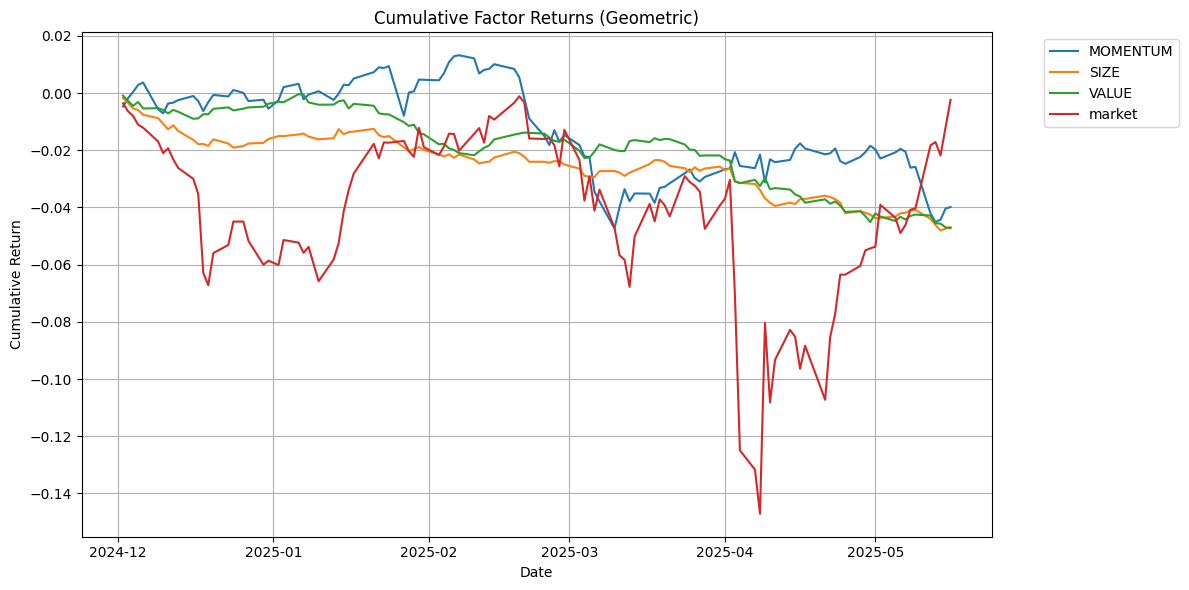

In [143]:
#factor_return_cols = [col for col in factor_returns.columns if col != 'date']
factor_return_cols = ['MOMENTUM','SIZE','VALUE',"market"]

# Expressions for geometric cumulative returns
cumulative_returns_exprs = []
for col_name in factor_return_cols:
    cumulative_returns_exprs.append(
        ((pl.col(col_name) + 1).cum_prod() - 1).alias(col_name) # Keep original name for simplicity
    )

cumulative_returns_df = factor_returns.select(
    [pl.col('date')] + cumulative_returns_exprs
)

# Plot cumulative factor returns
plt.figure(figsize=(12, 6))
for col_name in factor_return_cols: # Iterate through original factor names
    plt.plot(cumulative_returns_df['date'], cumulative_returns_df[col_name], label=col_name)
plt.title('Cumulative Factor Returns (Geometric)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
stats_exprs = []
for col_name in factor_return_cols:
    stats_exprs.append(pl.col(col_name).mean().alias(f"{col_name}_mean"))
    stats_exprs.append(pl.col(col_name).std().alias(f"{col_name}_std"))
    stats_exprs.append(pl.col(col_name).skew().alias(f"{col_name}_skew"))
    stats_exprs.append(pl.col(col_name).kurtosis().alias(f"{col_name}_kurtosis"))

factor_stats = factor_returns.select(stats_exprs)

print("\nFactor Return Statistics (Wide Format):")
print(factor_stats)


Factor Return Statistics (Wide Format):
shape: (1, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ MOMENTUM_ ┆ MOMENTUM_ ┆ MOMENTUM_ ┆ MOMENTUM_ ┆ … ┆ market_me ┆ market_st ┆ market_sk ┆ market_k │
│ mean      ┆ std       ┆ skew      ┆ kurtosis  ┆   ┆ an        ┆ d         ┆ ew        ┆ urtosis  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.000347 ┆ 0.004329  ┆ -1.241982 ┆ 2.920079  ┆ … ┆ 0.00007   ┆ 0.013569  ┆ 0.653747  ┆ 11.58894 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘


In [ ]:
# Pick 5 sample stocks from whatever is actually in the residuals
stock_cols = [c for c in residual_returns.columns if c != 'date']
# Try well-known tickers first, fall back to whatever is available
preferred = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM']
sample_stocks = [s for s in preferred if s in stock_cols]
if len(sample_stocks) < 5:
    remaining = [s for s in stock_cols if s not in sample_stocks]
    sample_stocks += remaining[:5 - len(sample_stocks)]

print(f"Sample stocks for residual analysis: {sample_stocks}")

residual_stats_exprs = []
for stock_symbol in sample_stocks:
    residual_stats_exprs.append(pl.col(stock_symbol).mean().alias(f"{stock_symbol}_mean"))
    residual_stats_exprs.append(pl.col(stock_symbol).std().alias(f"{stock_symbol}_std"))
    residual_stats_exprs.append(pl.col(stock_symbol).skew().alias(f"{stock_symbol}_skew"))
    residual_stats_exprs.append(pl.col(stock_symbol).kurtosis().alias(f"{stock_symbol}_kurtosis"))

residual_stats = residual_returns.select(residual_stats_exprs)

print("\nResidual Statistics for Sample Stocks (Wide Format):")
print(residual_stats)

# Plot residual return distribution for first sample stock
plt.figure(figsize=(10, 6))
sns.histplot(residual_returns[sample_stocks[0]], kde=True, stat="density", common_norm=False)
plt.title(f'Residual Return Distribution for {sample_stocks[0]}')
plt.xlabel('Residual Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Factor Covariance Estimation (Barra-style)

Estimate the full factor covariance matrix using:
1. **EWMA covariance** — exponentially-weighted, recent observations matter more
2. **Newey-West adjustment** — corrects for autocorrelation in daily factor returns
3. **Eigenvalue adjustment** — ensures positive definiteness (floor clipping)
4. **Specific risk** — per-stock idiosyncratic variance

In [ ]:
from toraniko.factor_cov import ewma_cov, newey_west_adjust, eigen_adjust, specific_risk, estimate_factor_cov

# Use all available data (T observations) with ~90 day half-life
T = factor_returns.height
window = T  # use all available observations
half_life = min(90, T // 2)

# Full pipeline: EWMA → Newey-West → Eigenvalue adjustment + Specific risk
factor_cov, factor_names, spec_risk_df = estimate_factor_cov(
    factor_returns, residual_returns,
    window=window, half_life=half_life, max_lag=2,
    eigen_method="floor", floor_ratio=1e-4,
)

print(f"Factor covariance matrix shape: {factor_cov.shape}")
print(f"Number of factors: {len(factor_names)}")
print(f"Factors: {factor_names}")
print(f"\nEigenvalues (all should be > 0):")
eigvals = np.linalg.eigvalsh(factor_cov)
print(eigvals)
print(f"\nSpecific risk (first 10 stocks):")
print(spec_risk_df.head(10))

In [ ]:
# Factor Correlation Heatmap
# Convert covariance to correlation: corr_ij = cov_ij / (sigma_i * sigma_j)
std_devs = np.sqrt(np.diag(factor_cov))
corr_matrix = factor_cov / np.outer(std_devs, std_devs)

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True  # mask upper triangle
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r",
    xticklabels=factor_names, yticklabels=factor_names,
    vmin=-1, vmax=1, center=0, mask=mask,
    square=True, linewidths=0.5, ax=ax,
)
ax.set_title("Factor Correlation Matrix (Barra EWMA + Newey-West)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Eigenvalue Spectrum — shows how variance is distributed across principal components
eigenvalues = np.linalg.eigvalsh(factor_cov)
eigenvalues_sorted = np.sort(eigenvalues)[::-1]  # largest first
explained_var = eigenvalues_sorted / eigenvalues_sorted.sum()
cumulative_var = np.cumsum(explained_var)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of eigenvalues
ax1.bar(range(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted, color="steelblue", alpha=0.8)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Eigenvalue")
ax1.set_title("Eigenvalue Spectrum of Factor Covariance")
ax1.set_xticks(range(1, len(eigenvalues_sorted) + 1))

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, "o-", color="darkorange", linewidth=2)
ax2.axhline(y=0.9, color="gray", linestyle="--", alpha=0.7, label="90% threshold")
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Variance Explained")
ax2.set_ylim(0, 1.05)
ax2.set_xticks(range(1, len(cumulative_var) + 1))
ax2.legend()

plt.tight_layout()
plt.show()

# How many PCs needed for 90%?
n_90 = np.searchsorted(cumulative_var, 0.9) + 1
print(f"Components needed for 90% variance: {n_90} out of {len(eigenvalues_sorted)}")
print(f"Top eigenvalue explains {explained_var[0]*100:.1f}% of total variance")

In [ ]:
# Annualized Factor Volatilities — horizontal bar chart, sorted
annualized_vols = std_devs * np.sqrt(252)  # daily → annual
vol_order = np.argsort(annualized_vols)[::-1]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(
    [factor_names[i] for i in vol_order],
    annualized_vols[vol_order] * 100,
    color="teal", alpha=0.8
)
ax.set_xlabel("Annualized Volatility (%)")
ax.set_title("Annualized Factor Volatilities (EWMA + Newey-West)")
ax.invert_yaxis()  # largest at top

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nMarket factor annualized vol: {annualized_vols[factor_names.index('market')]*100:.1f}%")

In [ ]:
# Specific Risk Distribution — histogram of annualized stock-level idiosyncratic vol
ann_spec_vol = spec_risk_df["specific_vol"].to_numpy() * np.sqrt(252) * 100  # annualized %

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ann_spec_vol, bins=40, color="salmon", edgecolor="white", alpha=0.85)
ax.axvline(np.median(ann_spec_vol), color="black", linestyle="--", linewidth=1.5,
           label=f"Median = {np.median(ann_spec_vol):.1f}%")
ax.set_xlabel("Annualized Specific Volatility (%)")
ax.set_ylabel("Number of Stocks")
ax.set_title("Distribution of Stock-Level Idiosyncratic Volatility")
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Stocks: {len(ann_spec_vol)}")
print(f"Median specific vol: {np.median(ann_spec_vol):.1f}%")
print(f"Min: {ann_spec_vol.min():.1f}%  |  Max: {ann_spec_vol.max():.1f}%")

In [ ]:
# Newey-West Impact — compare base EWMA variances vs NW-adjusted variances
cov_base, _ = ewma_cov(factor_returns, window=window, half_life=half_life)
cov_nw = newey_west_adjust(factor_returns, cov_base, window=window, half_life=half_life, max_lag=2)

base_var = np.diag(cov_base) * 252 * 1e4  # annualized, in bps²
nw_var = np.diag(cov_nw) * 252 * 1e4

nw_impact = pl.DataFrame({
    "Factor": factor_names,
    "Base Vol (ann %)": (np.sqrt(np.diag(cov_base)) * np.sqrt(252) * 100).tolist(),
    "NW Vol (ann %)": (np.sqrt(np.diag(cov_nw)) * np.sqrt(252) * 100).tolist(),
    "Change (%)": ((np.sqrt(np.diag(cov_nw)) / np.sqrt(np.diag(cov_base)) - 1) * 100).tolist(),
})
print("Newey-West Autocorrelation Adjustment Impact:")
print("(Positive change = autocorrelation inflates true variance)")
print(nw_impact)

# Bar chart comparing base vs NW
x = np.arange(len(factor_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - width / 2, np.sqrt(np.diag(cov_base)) * np.sqrt(252) * 100,
       width, label="EWMA Base", color="steelblue", alpha=0.8)
ax.bar(x + width / 2, np.sqrt(np.diag(cov_nw)) * np.sqrt(252) * 100,
       width, label="Newey-West Adjusted", color="darkorange", alpha=0.8)
ax.set_ylabel("Annualized Vol (%)")
ax.set_title("EWMA vs Newey-West Adjusted Factor Volatilities")
ax.set_xticks(x)
ax.set_xticklabels(factor_names, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()